In [64]:
#import spikeinterface modules
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import numpy as np
import glob

#import everything else
import os
import sys
import numpy as np
import neo
import pandas as pd
import scipy

# MCS
import McsPy
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_

# Plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

#SK Learn
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#networkx
import plotly.graph_objects as go
import networkx as nx
import matplotlib.patches as mpatches

from time import strftime
%matplotlib notebook



## Notebook from Spiketrains --> Bursts via ISI Detection

In [9]:
working_directory = r"D:\Files_Reutlingen_Jenny\main_191023\191023_paper\analysis_spontaneous"

output_directory = r"D:\Files_Reutlingen_Jenny\main_191023\191023_paper\analysis_spontaneous"

In [10]:
os.chdir(working_directory)

In [11]:
filename= 'spontaneous'

In [17]:
filelist = glob.glob('*.npy')


In [18]:
filelist

['filename_completerecording_full_spikedic.npy',
 'spontaneous.h5_0_120_info_dict.npy']

In [19]:
'''

# get into every folder and find the dictionaries
# replace them in a two meta-dictionaries (infodics and spikedics)
infodics = {}
spikedics = {}

for folder in folderlist:
    os.chdir(os.path.join(working_directory, folder))
    timekey = folder.split('_')[2:5]
    timekey = '_'.join(timekey)
    
    # load the info_dic_file
    info_dic_filename = glob.glob('*info*')[0]
    info_dic = np.load(info_dic_filename, allow_pickle=True).item()
    infodics[timekey] = info_dic
    
    # load the spikedic_file
    spike_dic_filename = glob.glob('*spikes_MAD*')[0]
    spikedic_MAD = np.load(spike_dic_filename, allow_pickle=True).item()
    spikedics[timekey] = spikedic_MAD
    
'''

"\n\n# get into every folder and find the dictionaries\n# replace them in a two meta-dictionaries (infodics and spikedics)\ninfodics = {}\nspikedics = {}\n\nfor folder in folderlist:\n    os.chdir(os.path.join(working_directory, folder))\n    timekey = folder.split('_')[2:5]\n    timekey = '_'.join(timekey)\n    \n    # load the info_dic_file\n    info_dic_filename = glob.glob('*info*')[0]\n    info_dic = np.load(info_dic_filename, allow_pickle=True).item()\n    infodics[timekey] = info_dic\n    \n    # load the spikedic_file\n    spike_dic_filename = glob.glob('*spikes_MAD*')[0]\n    spikedic_MAD = np.load(spike_dic_filename, allow_pickle=True).item()\n    spikedics[timekey] = spikedic_MAD\n    \n"

In [24]:
# das hier im Anschluss mit dem Complete Spikedic Ersetzen

spikedic_MAD = np.load(filelist[0], allow_pickle=True).item()
infodic = np.load(filelist[1], allow_pickle=True).item()

In [41]:
# we gather the general information


tick = infodic['tick']
# the timelength recording must be set to 120 seconds if we observe
timelengthrecording_s = infodic['timelengthrecording_s']
first_recording_timepoint = infodic['first_recording_timepoint']
scale_factor_for_second = infodic['scale_factor_for_second']
scale_factor_for_milisecond = scale_factor_for_second/1000


#### Definition of all Functions for the Interspike Interval Method


In [26]:
def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning. 
        It returns an ascending list of tuples, representing the intervals.
        A tuple bins[i], i.e. (bins[i][0], bins[i][1])  with i > 0 
        and i < quantity, satisfies the following conditions:
            (1) bins[i][0] + width == bins[i][1]
            (2) bins[i-1][0] + width == bins[i][0] and
                bins[i-1][1] + width == bins[i][1]
    """
    

    bins = []
    for low in range(lower_bound, 
                     lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins


def find_bin(value, bins):
    """ bins is a list of tuples, like [(0,20), (20, 40), (40, 60)],
        binning returns the smallest index i of bins so that
        bin[i][0] <= value < bin[i][1]
    """
    
    for i in range(0, len(bins)):
        if bins[i][0] <= value < bins[i][1]:
            return i
    return -1



def find_binned_spikes(data, bins):
    '''
    Parameters
    ----------
    data : for network spike binning --> expects an 1D array with all spikes detected for the network
    bins : list of tuples of expected bins

    Returns
    -------
    binlist : list of lists where lists contain all spikes for the respective bins

    '''
    binlist =[]
    binspike =[]
    for i in range(0, len(bins)):
        binspike = []
        for a in data:    
            if bins[i][0] <= a < bins[i][1]:
                binspike.append(a)
        binlist.append(binspike)
            
    return binlist




def get_isi_singlechannel(spikedic, tick):
    '''
    Parameters
    ----------
    spikedic : dictionary with all detected spikes for a channel
        DESCRIPTION.

    Returns
    -------
    isidic : keys = channels, values = List of tuples where tuple[0]=detected spike and tuple[1]=isi to the next detected spike
    isi_alone_dic : keys = channels, values = list of isi alone
    CAVE returns are in microseconds
    '''
    
    isidic ={}     
    isilist = []
    isi_alone_dic = {}
    isislist =[]

    for key in spikedic:
        isilist = []
        isislist = []
        if len(spikedic[key])>=2:
            for i in range(0, (len(spikedic[key])-1)):
                isi = spikedic[key][i]*tick, (spikedic[key][i+1]-spikedic[key][i])*tick #CL tick für beide dazu
                isi_alone = (spikedic[key][i+1]-spikedic[key][i])*tick
                isilist.append(isi)
                isislist.append(isi_alone)
        isidic[key]=isilist
        isi_alone_dic[key]=isislist
        
    return isidic, isi_alone_dic



def bin_isi(isi_alone_dic, binsize, binmax=bool, binmaxnumber=None):
    '''

    Parameters
    ----------
    isi_alone_dic : dic
        dictionary with all ISI for every channel
    binsize: int
        expects int in microseconds that defines bin-width
    Returns
    -------
    histo_ISI_dic:
        dic with key:channellabel, value: list with bincounts per bin

    '''
    isi_bins = []
    isi_bins_list = []
    isi_bin_count = []
    histo_ISI_dic = {}
    for key in isi_alone_dic:
        if binmax==True:
            isi_bin_count=[]
            isibins=create_bins(0, binsize, binmaxnumber)
            isi_bins_list=[] 
            for i in range(0, len(isibins)):
                isi_bins=[]
                for a in isi_alone_dic[key]:
                    if isibins[i][0] <= a < isibins[i][1]:
                        isi_bins.append(a)
                isi_bins_list.append(isi_bins)
            for i in range(0, (len(isi_bins_list)-1)):
                isi_bin_count.append(len(isi_bins_list[i]))
            histo_ISI_dic[key]=isi_bin_count
        #else:
            # noch schreiben für variable maximalnummer an bins
            
    return histo_ISI_dic


def bin_lnisi(isi_alone_dic, start_in_microseconds, stop_in_microseconds, totalbins, binmax):
    '''

    Parameters
    ----------
    isi_alone_dic : dic
        dictionary with all ISI for every channel 
    binsize: int
        expects int in microseconds that defines bin-width
    Returns
    -------
    histo_ISI_dic:
        dic with key:channellabel, value: list with bincounts per logarithmic spaced bins

    '''
    isi_bins = []
    isi_bins_list = []
    isi_bin_count = []
    histo_ln_ISI_dic = {}
    for key in isi_alone_dic:
        if binmax==True:
            isi_bin_count=[]
            isibins=create_ln_bins(start_in_microseconds, stop_in_microseconds, totalbins)
            isi_bins_list=[] 
            for i in range(0, len(isibins)):
                isi_bins=[]
                for a in isi_alone_dic[key]:
                    if isibins[i][0] <= a < isibins[i][1]:
                        isi_bins.append(a)
                isi_bins_list.append(isi_bins)
            for i in range(0, (len(isi_bins_list)-1)):
                isi_bin_count.append(len(isi_bins_list[i]))
            histo_ln_ISI_dic[key]=isi_bin_count
        #else:
            # noch schreiben für variable maximalnummer an bins
            
    return histo_ln_ISI_dic, isibins


def get_allchannel_ISI_bins(histo_ISI_dic):
    '''
    Parameters
    ----------
    histo_ISI_dic : dic mit den einzelnen ISI für jeden Channel. Cave, die Values müssen alle die gleiche
                    Länge haben, sonst funktioniert die zip Funktion nicht.
        DESCRIPTION.

    Returns
    -------
    network_ISI_binned = array of all ISI of the whole network binned

    '''
    network_ISI = []
    for key in histo_ISI_dic:
        list1 = histo_ISI_dic[key]
        if len(list1)>len(network_ISI):
            network_ISI=list1
        else:
            list2 = network_ISI
            network_ISI = [a + b for a, b in zip(list1, list2)]
    return np.array(network_ISI)


def get_burst_threshold(df_with_CMA):
    '''
    

    Parameters
    ----------
    df_with_CMA : TYPE
        DESCRIPTION.

    Returns
    -------
    CMAalpha : TYPE
        DESCRIPTION.
    CMAalpha2 : TYPE
        DESCRIPTION.
    maxCMA : TYPE
        DESCRIPTION.
    alpha1 : TYPE
        DESCRIPTION.
    alpha2 : TYPE
        DESCRIPTION.

    '''
    
    networkburstthreshold_ISI = 200000 #wie im paper maximal bei 200 ms als isi
    skewness = scipy.stats.skew(network_ISI)
    if skewness < 1:
        alpha1 = 1
        alpha2 = 0.5
    elif skewness >= 1 and skewness <4:
        alpha1 = 0.7
        alpha2 = 0.3
    elif skewness >=4 and skewness <9:
        alpha1 = 0.5
        alpha2 = 0.3
    elif skewness >=9:
        alpha1 = 0.3
        alpha2 = 0.1
    maxCMA = max(df_with_CMA['CMA'])
    CMAalpha = maxCMA*alpha1
    CMAalpha2 = maxCMA*alpha2
    return CMAalpha, CMAalpha2, maxCMA, alpha1, alpha2


def ISI_threshold_min(df_with_CMA, CMAalpha, CMAalpha2, binsize_in_micros):
    '''
    '''
    indexfactor = df[df['CMA']>CMAalpha].index[-1] + 1
    indexfactor2 = df[df['CMA']>CMAalpha2].index[-1] + 1
    threshold_intraburst = float(indexfactor*binsize_in_micros)
    threshold_burst_related = float(indexfactor2*binsize_in_micros)
    
    return threshold_intraburst, threshold_burst_related


def find_burst_starts(isi_alone, threshold_intraburst, spikedic):
    '''
    Parameters
    ----------
    isi_alone : TYPE
        DESCRIPTION.
    threshold_intraburst : TYPE
        DESCRIPTION.
    spikedic : TYPE
        DESCRIPTION.

    Returns
    -------
    None.

    '''
    burststartdic = {}
    noburstlist = []
    #burststartlist = []
    for key in isi_alone:
        #print(key)
        if len(isi_alone[key])<3:
            noburstlist.append(isi_alone[key])
        burststartlist=[]
        counter = 0
        while counter < (len(isi_alone[key])-4):
            setter = 0
            if isi_alone[key][counter]<threshold_intraburst:
                setter +=1
                if isi_alone[key][counter+setter] < threshold_intraburst:
                    setter +=1
                    if isi_alone[key][counter+setter] < threshold_intraburst:
                        burststartlist.append((spikedic[key][counter])*tick) #CL: zusätzlich times tick to get all timestamps in ms
                        setter += 1
                        while isi_alone[key][counter+setter]<threshold_intraburst and (counter+setter)< (len(isi_alone[key])-4):
                            setter +=1
                            #print('burst '+str(setter))
                        setter +=1
                    else:
                        counter +=1
                else:
                    counter +=1
                counter = counter + setter + 1
            else:
                counter +=1
            #print(str(key) + str(counter))
        burststartdic[key]=burststartlist
        
    return burststartdic   


def find_burst_starts_and_length(isi_alone, threshold_intraburst, spikedic):
    '''
    Parameters
    ----------
    isi_alone : TYPE
        DESCRIPTION.
    threshold_intraburst : TYPE
        DESCRIPTION.
    spikedic : TYPE
        DESCRIPTION.

    Returns
    -------
    None.

    '''
    burststartdic = {}
    noburstlist = []
    #burststartlist = []
    for key in isi_alone:
        #print(key)
        if len(isi_alone[key])<3:
            noburstlist.append(isi_alone[key])
        burststartlist=[]
        counter = 0
        while counter < (len(isi_alone[key])-4):
            setter = 0
            if isi_alone[key][counter]<threshold_intraburst:
                setter +=1
                if isi_alone[key][counter+setter] < threshold_intraburst:
                    setter +=1
                    if isi_alone[key][counter+setter] < threshold_intraburst:
                        burststart_spike = spikedic[key][counter]*tick
                        burstend_spike = spikedic[key][counter+setter]*tick
                        #burststartlist.append((spikedic[key][counter])*tick) #CL: zusätzlich times tick to get all timestamps in ms
                        setter += 1
                        while isi_alone[key][counter+setter]<threshold_intraburst and (counter+setter)< (len(isi_alone[key])-4):
                            setter +=1
                            burstend_spike = spikedic[key][counter+setter]*tick
                            #print('burst '+str(setter))
                        burststartlist.append((burststart_spike, burstend_spike))
                        setter +=1
                    else:
                        counter +=1
                else:
                    counter +=1
                counter = counter + setter + 1
            else:
                counter +=1
            #print(str(key) + str(counter))
        burststartdic[key]=burststartlist
        
    return burststartdic   


### ISI Burst Detection

In [27]:
# we st_channel is the dictionary with all spikes per channel
st_channel = spikedic_MAD

In [28]:
binsize_for_ISI = 5000 #in microseconds

In [29]:
isidic, isi_alone = get_isi_singlechannel(st_channel, tick) #creates two dictionaries
histo_ISI_dic=bin_isi(isi_alone, binsize=binsize_for_ISI, 
                      binmax=True, binmaxnumber=200) # dictionary für jeden channel mit 300x 10ms bins (binsize) und der Menge an ISI für die jeweilige Länge
network_ISI=get_allchannel_ISI_bins(histo_ISI_dic) #gibt ein array mit bins entsprechend der bins aus der Vorfunktion


In [31]:
colors = ['green', 'blue', 'orange', 'purple']

<IPython.core.display.Javascript object>


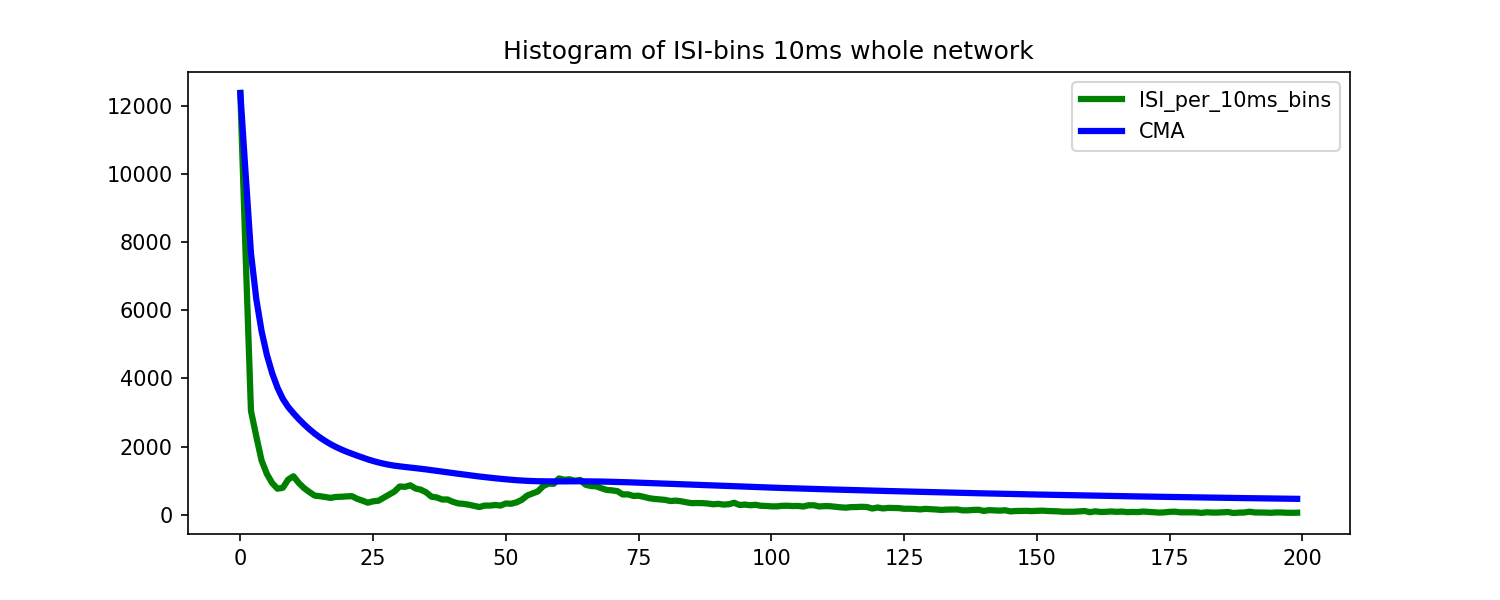

<AxesSubplot:title={'center':'Histogram of ISI-bins 10ms whole network'}>

In [32]:
df= pd.DataFrame({'ISI_per_10ms_bins':network_ISI}) #aus Network_ISI wird ein pdDF um die weiteren Schritte durchführen zu können
df["CMA"] = df.ISI_per_10ms_bins.expanding().mean()
df[['ISI_per_10ms_bins', 'CMA']].plot(color=colors, linewidth=3, 
                                      figsize=(10,4), 
                                      title="Histogram of ISI-bins 10ms whole network")

In [33]:
# next calculation of the adaptive thresholds:
CMAalpha, CMAalpha2, maxCMA, alpha1, alpha2=get_burst_threshold(df) # threshold calculation
threshold_intraburst, threshold_burst_related = ISI_threshold_min(df, CMAalpha, 
                                                                  CMAalpha2, binsize_for_ISI) #set thresholds

In [34]:
CMAalpha, CMAalpha2, maxCMA, alpha1, alpha2

(6185.0, 3711.0, 12370.0, 0.5, 0.3)

10ms: (544.5, 181.5, 1815.0, 0.3, 0.1)


5ms: (357.3, 119.10000000000001, 1191.0, 0.3, 0.1)

1ms: (112.89999999999999, 37.63333333333333, 376.3333333333333, 0.3, 0.1)

0.5ms (61.08, 20.36, 203.6, 0.3, 0.1)

0.1ms (51.5, 30.9, 103.0, 0.5, 0.3)

In [35]:
threshold_intraburst, threshold_burst_related

(20000.0, 40000.0)

10ms threshold_intraburst 50000, 230000

5ms threshold_intraburst: 35000 , related 145000

1ms intraburst: 20000, related: 80.000

0.5ms intraburst 35.000, related: 145.000

Single channel bursts were calculated using an adapted version of the Network-CMA method proposed by Välkki and colleagues (Välkki et al. 2017): In brief, interspike-intervals (ISI) of each recording were binned in 5ms bins and a cumulative moving-average over the resulting histogram was calculated. The maximum value of the CMA (maximal CMA) was then used to calculate the maximal ISI between at spikes of one channel: Depending on the skewness of the histogram, the maximal CMA was modified with a cofactor alpha to identify the threshold for intraburst ISI (0.3 < alpha < 1 ) and burst-related ISI (0.1 < alpha < 0.5). Since we were interested in spatial networks, we decided to define single-channel bursts as a sequence of at least 3 consecutive spikes with an ISI below the calculated burst related ISI. To improve comparability between recordings, we defined a range from 60 - 140 ms as reasonable values for burst-related ISI. Thus, we hope to use the best of both worlds for single channel burst detection: Leveraging the adaptability of the Network-CMA method while ensuring comparability between variably-active slices. 


In [36]:
final_threshold = 0

if threshold_burst_related > 140000:
    final_threshold = 140000
elif threshold_burst_related < 60000:
    final_threshold = 60000
else:
    final_threshold = threshold_burst_related

In [37]:
print('The final threshold for this recoding is: %s' %final_threshold)
    
    

The final threshold for this recoding is: 60000


In [38]:
burststart_end_dic = find_burst_starts_and_length(isi_alone, final_threshold, st_channel) 

<IPython.core.display.Javascript object>


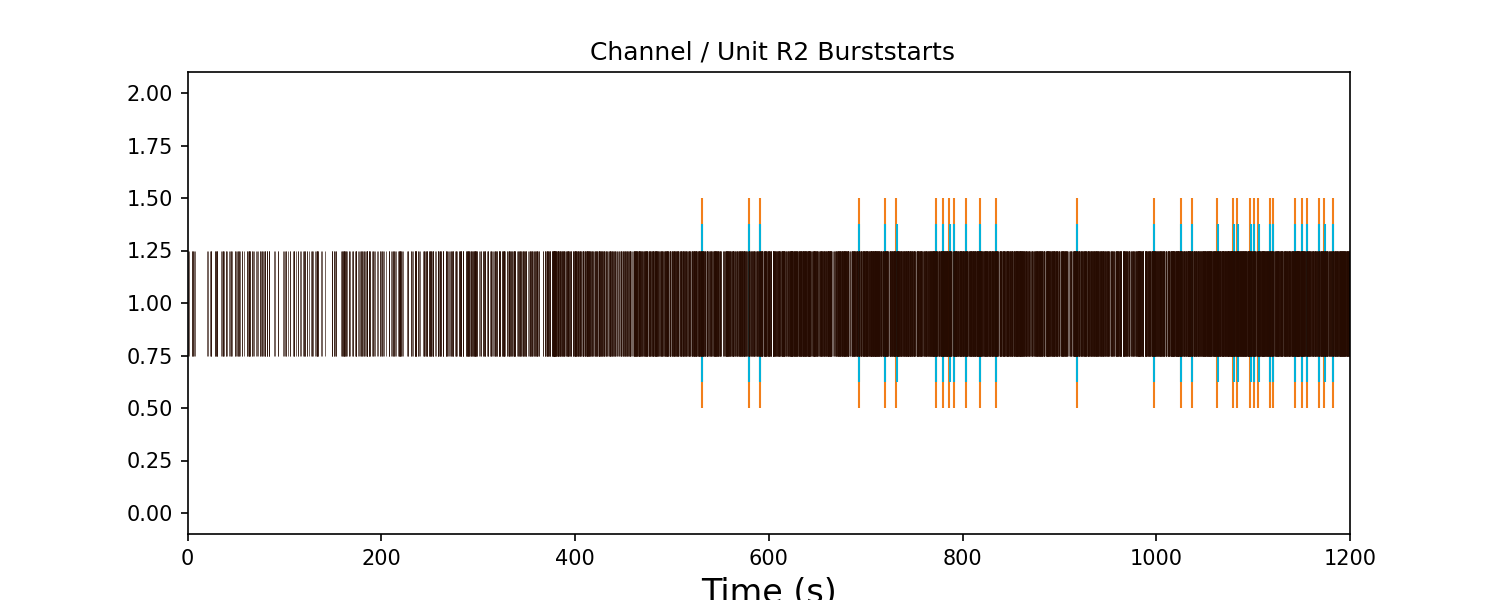

<IPython.core.display.Javascript object>


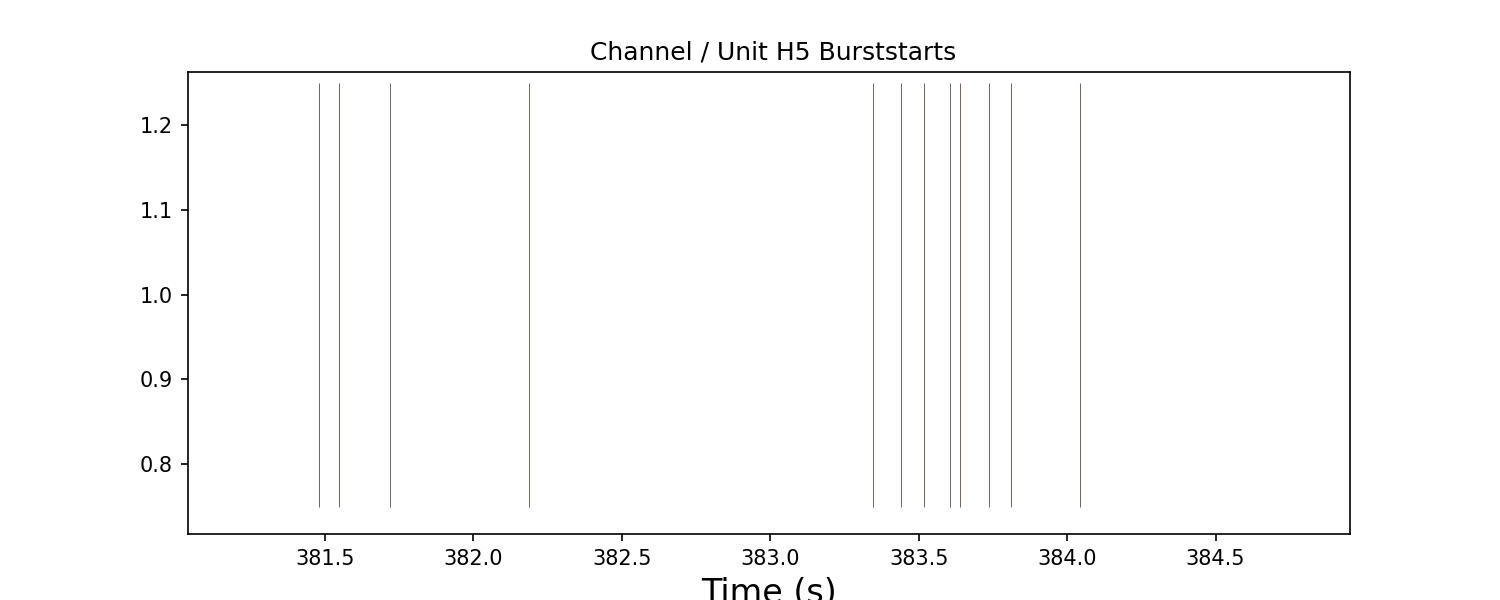

<IPython.core.display.Javascript object>


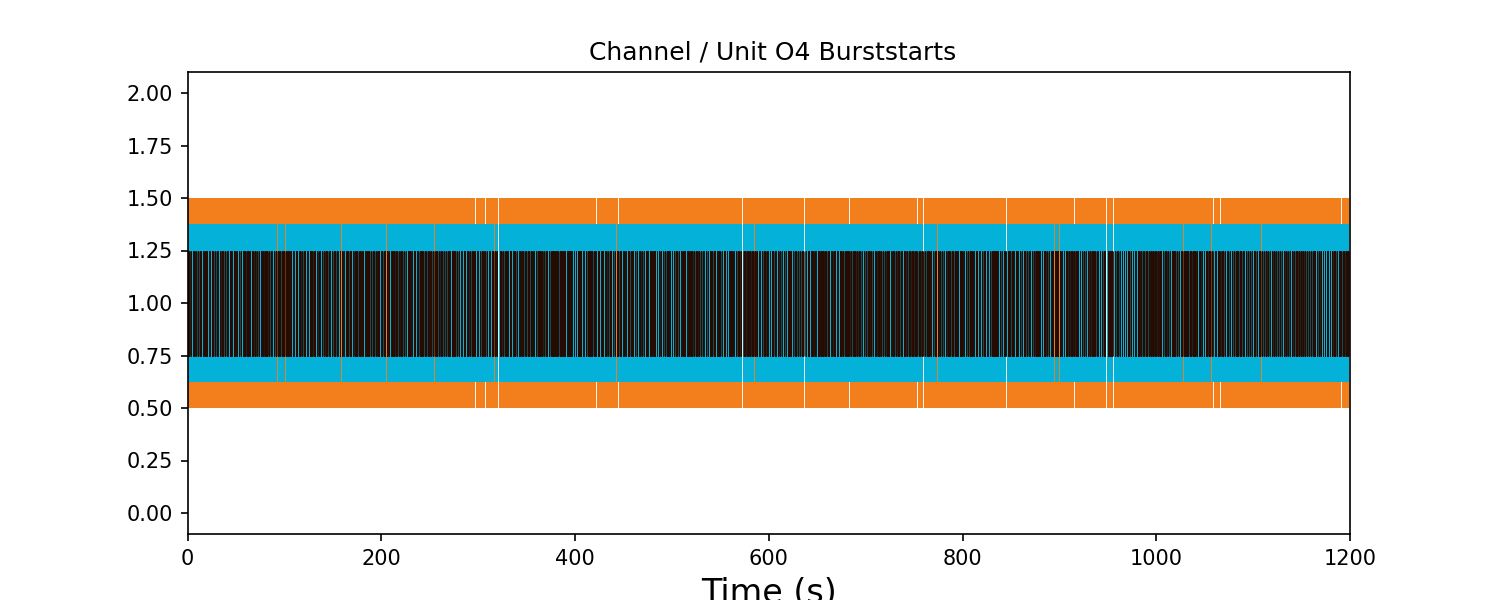

<IPython.core.display.Javascript object>


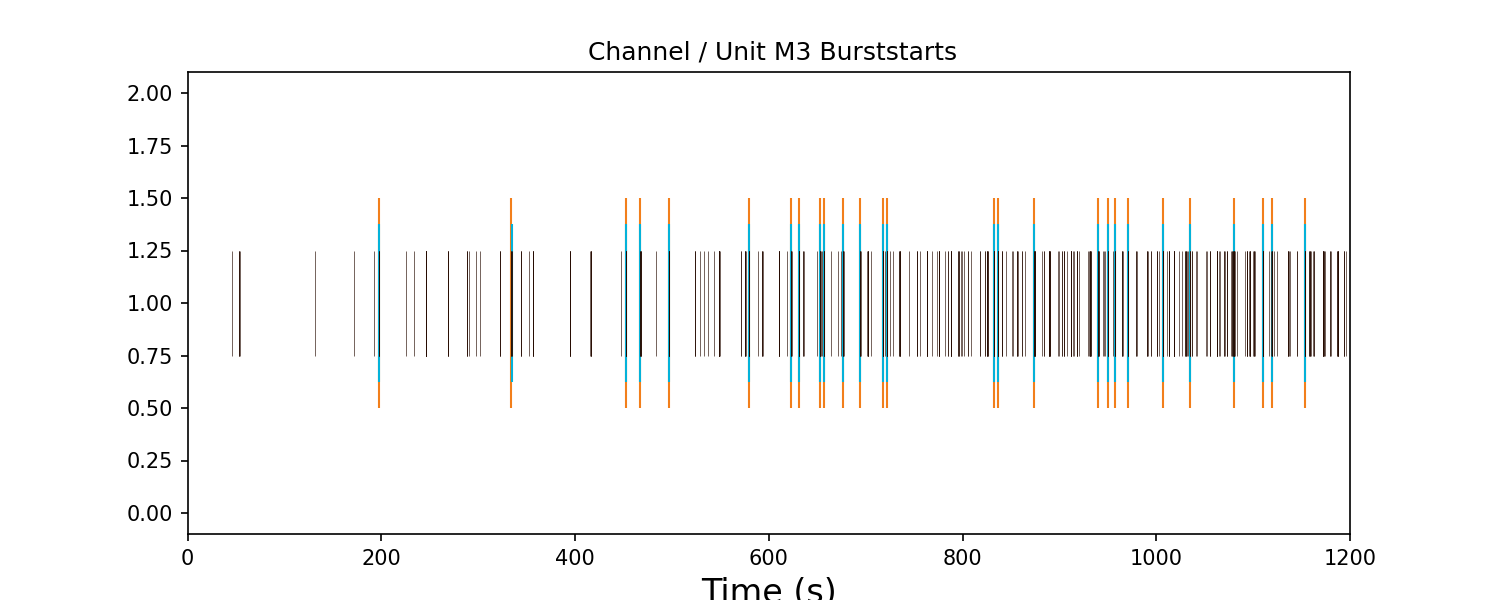

<IPython.core.display.Javascript object>


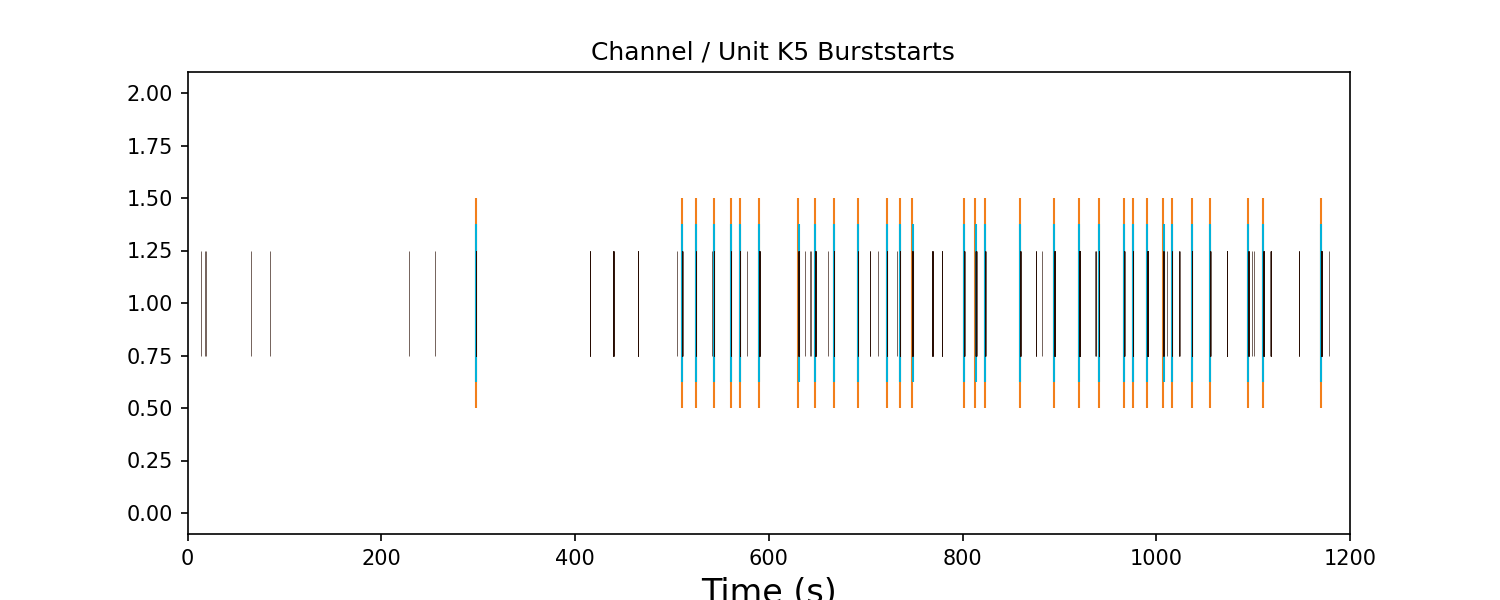

<IPython.core.display.Javascript object>


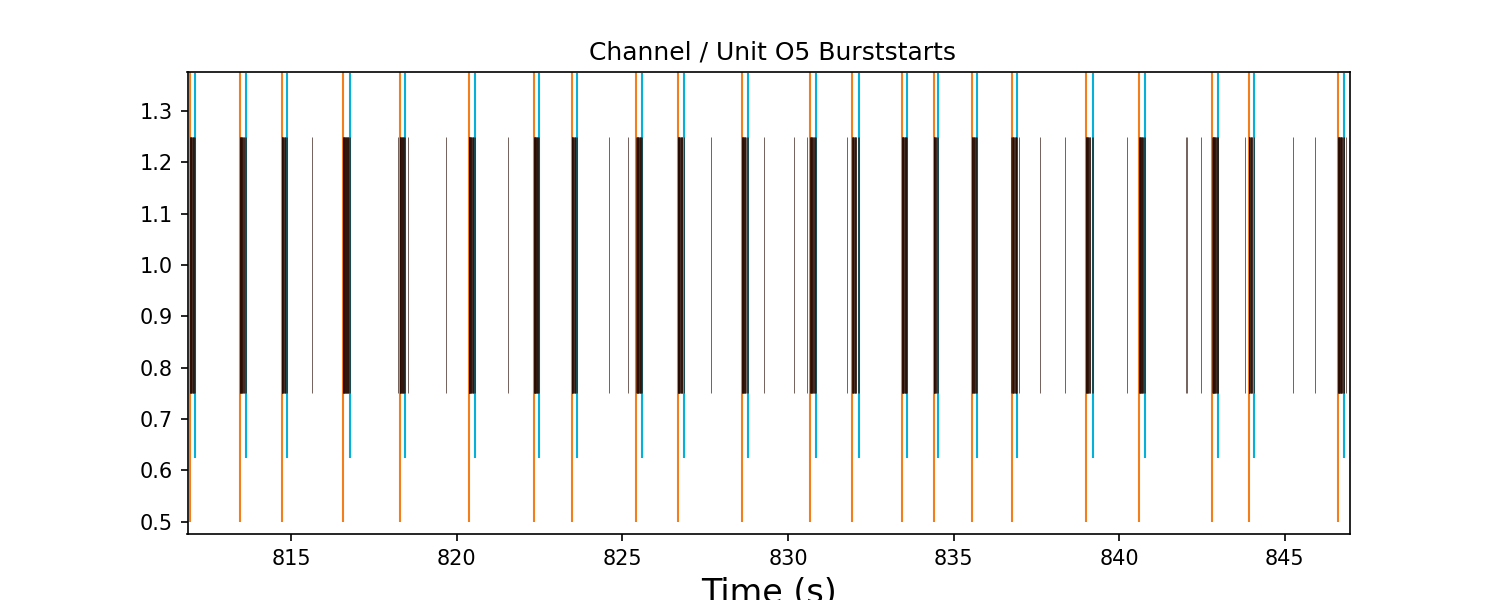

<IPython.core.display.Javascript object>


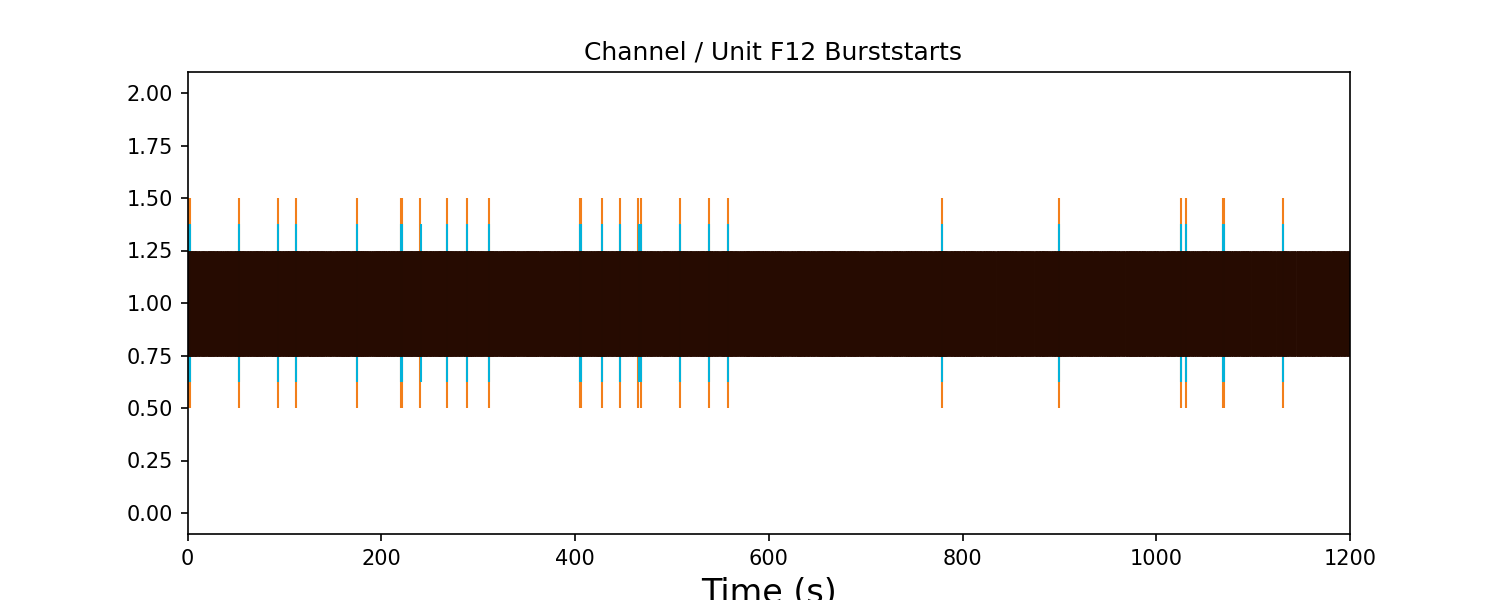

<IPython.core.display.Javascript object>


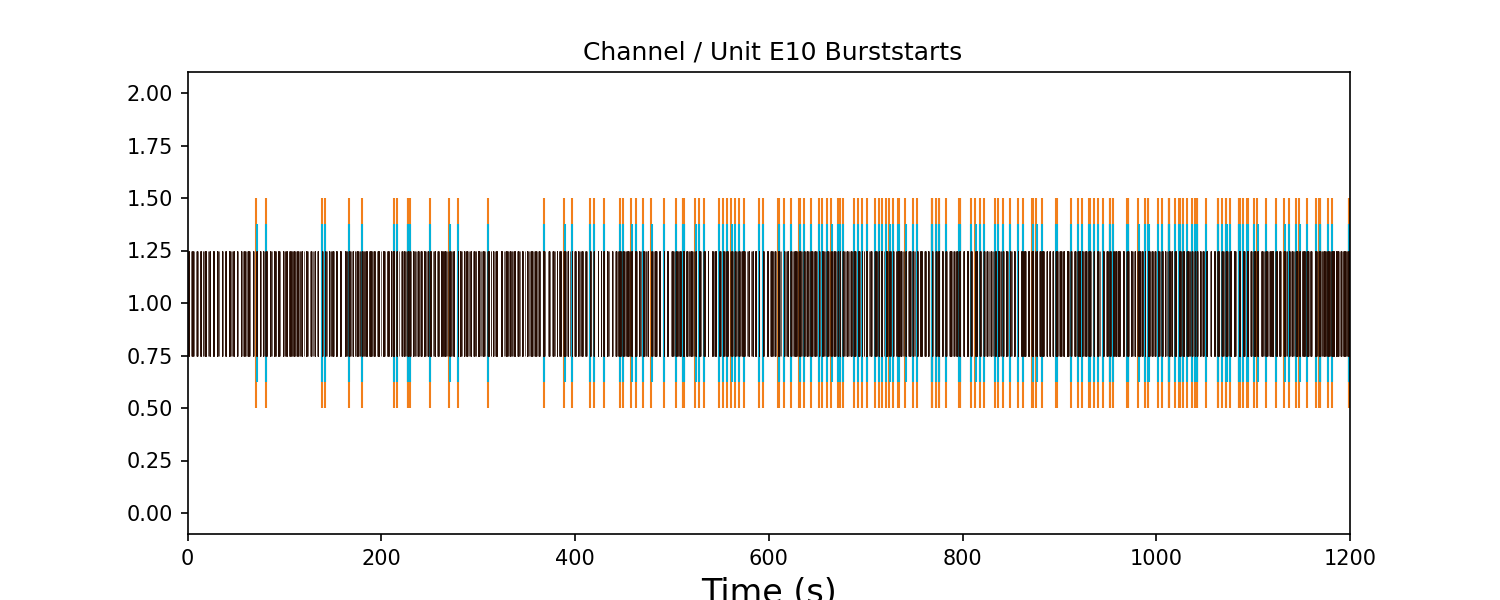

In [42]:
st_neurons = st_channel
for key in burststart_end_dic:
    burststarts_array = []
    burstend_array = []
    for i in range(0, len(burststart_end_dic[key])):
        start = burststart_end_dic[key][i][0]*scale_factor_for_second
        end = burststart_end_dic[key][i][1]*scale_factor_for_second
        burststarts_array.append(start)
        burstend_array.append(end)

    array = np.array(st_neurons[key]).flatten()*40*scale_factor_for_second
    #burststarts = np.array(burststartdic[key]).flatten()*scale_factor_for_second
    
    #if len(array) > 20:
    if len(burststarts_array) > 20:
        fig = plt.figure(figsize=(10, 4))
        ax = fig.add_subplot(1, 1, 1)
        ax.eventplot(burststarts_array, linelengths = 1, linewidth = 1, color='#F27F1B')
        ax.eventplot(burstend_array, linelengths = 0.75, linewidth = 1, color='#04B2D9')
        ax.eventplot(array, linelengths= 0.5, linewidth = 0.3, color='#260B01')
        #ax.eventplot(trigger_on_seconds, linelengths=0.75, color='blue')
        ax.set_xlabel('Time (s)', fontsize=16)
        ax.set_title(' Channel / Unit '+str(key) +' Burststarts')
        ax.set_xlim(0, timelengthrecording_s)
        #ax.set_ylabel('Channel % - Eventplot with burststarts' %str(key))
        #ax.set_ylabel('Channel '+str(key) +' Burststarts')


        plt.show()
        #fig.savefig(str(filename) +'_burstplot_'+str(key)+'.png')
        #plt.close()

In [43]:
burststart_end_dic

{'R12': [],
 'L10': [],
 'O10': [],
 'P11': [],
 'L9': [],
 'N9': [],
 'M8': [],
 'R8': [],
 'O6': [],
 'N7': [],
 'R4': [],
 'P5': [],
 'R2': [(531295480.0, 531406760.0),
  (579764000.0, 579979840.0),
  (590877080.0, 590978680.0),
  (693268800.0, 693380240.0),
  (720124560.0, 720210440.0),
  (731861360.0, 731965720.0),
  (772696600.0, 772800120.0),
  (779361640.0, 779457120.0),
  (786483520.0, 786584480.0),
  (790993120.0, 791086280.0),
  (803493520.0, 803595840.0),
  (817718280.0, 817805400.0),
  (834486480.0, 834585840.0),
  (917798000.0, 917898080.0),
  (997457280.0, 997716600.0),
  (1025647840.0, 1025746240.0),
  (1036691080.0, 1036793880.0),
  (1063220240.0, 1063318360.0),
  (1079639960.0, 1079744200.0),
  (1083833280.0, 1083942000.0),
  (1097095120.0, 1097321760.0),
  (1101177800.0, 1101280640.0),
  (1105507120.0, 1105723440.0),
  (1117140480.0, 1117244400.0),
  (1120141320.0, 1120247360.0),
  (1142999000.0, 1143104560.0),
  (1150770240.0, 1150878960.0),
  (1155276200.0, 1155375

In [45]:
# for every unit, the whole time of bursts is calculated and put into a dictionary
bursting_time_per_unit_dic = {}
for key in burststart_end_dic:
    time = 0
    for i in burststart_end_dic[key]:
        bursttime = i[1] - i[0]
        time = time + bursttime
    bursting_time_per_unit_dic[key] = time*scale_factor_for_second # kein tick, vorher bereits drin

In [46]:
# for every unit, the whole time of bursts is calculated and put into a dictionary
bursts_per_unit_dic = {}
for key in burststart_end_dic:
    number_of_bursts = 0
    for i in burststart_end_dic[key]:
        number_of_bursts += 1
    bursts_per_unit_dic[key] = number_of_bursts

In [47]:
bursting_time_per_unit_dic

{'R12': 0.0,
 'L10': 0.0,
 'O10': 0.0,
 'P11': 0.0,
 'L9': 0.0,
 'N9': 0.0,
 'M8': 0.0,
 'R8': 0.0,
 'O6': 0.0,
 'N7': 0.0,
 'R4': 0.0,
 'P5': 0.0,
 'R2': 3.8474399999999997,
 'M5': 0.0,
 'K6': 0.0,
 'I8': 0.0516,
 'L2': 0.10912,
 'M1': 0.0,
 'I4': 0.97268,
 'K3': 0.03244,
 'H1': 0.0,
 'I6': 0.0,
 'G4': 0.0,
 'H5': 3.4291199999999997,
 'E2': 0.0,
 'F3': 0.0,
 'N13': 0.0,
 'O14': 0.0,
 'R13': 0.0,
 'L11': 0.0,
 'O11': 0.0,
 'P12': 0.0,
 'M9': 0.21275999999999998,
 'N10': 0.0,
 'L8': 0.0,
 'R9': 0.0,
 'O7': 0.0,
 'N8': 0.0,
 'R5': 0.0,
 'P6': 0.0,
 'K7': 0.0,
 'L7': 0.0,
 'N4': 0.0,
 'O3': 0.0,
 'N1': 0.20192,
 'L6': 0.04264,
 'L3': 0.0,
 'M2': 0.0,
 'I5': 0.05608,
 'K4': 0.0,
 'H6': 1.8166399999999998,
 'I1': 0.0,
 'G3': 0.0,
 'H4': 0.0,
 'E1': 0.0,
 'F2': 0.0,
 'K13': 0.0,
 'L16': 0.0,
 'I12': 0.0,
 'K15': 0.0,
 'I16': 0.0,
 'I14': 0.0,
 'K10': 0.0,
 'O16': 0.0,
 'R14': 0.0,
 'R15': 0.0,
 'O12': 0.0,
 'P13': 0.0,
 'M10': 0.0,
 'N11': 0.0,
 'P9': 0.0,
 'R10': 0.0,
 'O8': 0.0,
 'K8': 0.0

In [232]:
# this function takes the dictionary with every burst start and stop and returns a dictionary
# where every unit is a key and the values are tuples consisting of keys of connected units (i.e., bursting together)
# and the number of shared bursts


burst_connections_dic = {}


for key in burststart_end_dic:
    other_keys = list(burststart_end_dic.keys())
    other_keys.remove(key)
    connected_unit_list = []
    for j in other_keys:
        number_of_bursts = 0
        time_shared = 0
        for i in burststart_end_dic[key]:
            start, end = i[0], i[1]
            for m in burststart_end_dic[j]:
                other_start = m[0]
                other_end = m[1]
                if (other_start > start) & (other_start < end):
                    if other_end >= end:
                        time_shared = time_shared + (end - other_start)
                    else:
                        time_shared = time_shared + (other_end - other_start)
                    number_of_bursts += 1
                    
        if number_of_bursts > 0:
            connected_unit_list.append((j, number_of_bursts, time_shared*scale_factor_for_second))        
    burst_connections_dic[key] = connected_unit_list

In [233]:
np.save('191023_whole_recording_burst_connections_dic.npy', burst_connections_dic)

In [234]:
burst_connections_dic

{'R12': [],
 'L10': [],
 'O10': [],
 'P11': [],
 'L9': [],
 'N9': [],
 'M8': [],
 'R8': [],
 'O6': [],
 'N7': [],
 'R4': [],
 'P5': [],
 'R2': [('O4', 1, 0.1046), ('O5', 2, 0.19272)],
 'M5': [],
 'K6': [],
 'I8': [],
 'L2': [],
 'M1': [],
 'I4': [('H5', 1, 0.03812),
  ('O4', 1, 0.07307999999999999),
  ('O5', 1, 0.08864)],
 'K3': [],
 'H1': [],
 'I6': [],
 'G4': [],
 'H5': [('I4', 1, 0.030039999999999997),
  ('K3', 1, 0.012159999999999999),
  ('H6', 2, 0.2046),
  ('O4', 2, 0.12051999999999999),
  ('K5', 1, 0.03312),
  ('O5', 2, 0.10443999999999999),
  ('H2', 1, 0.17523999999999998),
  ('E10', 2, 0.07171999999999999)],
 'E2': [],
 'F3': [],
 'N13': [],
 'O14': [],
 'R13': [],
 'L11': [],
 'O11': [],
 'P12': [],
 'M9': [('O4', 2, 0.03576), ('O5', 2, 0.047)],
 'N10': [],
 'L8': [],
 'R9': [],
 'O7': [],
 'N8': [],
 'R5': [],
 'P6': [],
 'K7': [],
 'L7': [],
 'N4': [],
 'O3': [],
 'N1': [('M3', 1, 0.03076), ('K5', 1, 0.0007599999999999999)],
 'L6': [],
 'L3': [],
 'M2': [],
 'I5': [],
 'K4'

In [235]:
simple_burst_connection = {}

for key in burst_connections_dic:
    listed_connections = []
    for i in burst_connections_dic[key]:
        if i[1] > 0: # anzahl der geshareten bursts
        #if i[2] > 3: # Länge der gesharedten bursts in sec
        #if (i[1] > 10) & (i[2] > 1): # Länge der gesharedten bursts in sec
            listed_connections.append(i[0])
    simple_burst_connection[key] = listed_connections

In [236]:
# Reutlingen
all_channels = ['D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'I2', 'K1', 'K2', 'L1', 'L2', 'L3', 'M1', 'M2', 
                        'M3', 'M4', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 
                        'O7', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'R2', 'R3', 'R4', 'R5', 
                        'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 'R13', 'R14', 'R15', 'B1', 'B2', 'C1', 'C2', 'D2', 'E2', 'F2', 'G2', 'G3', 'H2', 'H3', 'I3', 'K3', 'K4', 
                         'L4', 'L5', 'M5', 'M6', 'M7', 'N7', 'N8', 'O8', 'O9', 'O10', 'O11', 'P10', 'P11', 
                         'P12', 'P13', 'P14', 'P15', 'P16', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'B3', 'B4', 'B5', 'B6', 
                         'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
                          'C11', 'C12', 'C13', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 
                         'D13', 'D14', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 
                         'E15', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 
                         'F16', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16', 
                         'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'I4', 
                         'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'K5', 'K6', 
                         'K7', 'K8', 'K9', 'K10', 'K11', 'K12', 'K13', 'K14', 'K15', 'K16', 'L6', 'L7', 'L8', 'L9', 
                         'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 
                         'M14', 'M15', 'M16', 'N9', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N16', 'O12', 'O13', 
                         'O14', 'O15', 'O16', 'A12', 'A13', 'A14', 'A15', 'B13', 'B14', 'B15', 'B16', 'C14', 'C15', 'C16', 'D15', 'D16', 'E16']

In [237]:
# layerdic 23.10.2019
layerdic = {'layer1':[ ], 
            'layer2-3': ['D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'I2', 'K1', 'K2', 'L1', 'L2', 'L3', 'M1', 'M2', 
                        'M3', 'M4', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 
                        'O7', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'R2', 'R3', 'R4', 'R5', 
                        'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 'R13', 'R14', 'R15'],
           'layer4':    ['B1', 'B2', 'C1', 'C2', 'D2', 'E2', 'F2', 'G2', 'G3', 'H2', 'H3', 'I3', 'K3', 'K4', 
                         'L4', 'L5', 'M5', 'M6', 'M7', 'N7', 'N8', 'O8', 'O9', 'O10', 'O11', 'P10', 'P11', 
                         'P12', 'P13', 'P14', 'P15', 'P16' ],
           'layer5-6':  ['A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'B3', 'B4', 'B5', 'B6', 
                         'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
                          'C11', 'C12', 'C13', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 
                         'D13', 'D14', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 
                         'E15', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 
                         'F16', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'G13', 'G14', 'G15', 'G16', 
                         'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'I4', 
                         'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'K5', 'K6', 
                         'K7', 'K8', 'K9', 'K10', 'K11', 'K12', 'K13', 'K14', 'K15', 'K16', 'L6', 'L7', 'L8', 'L9', 
                         'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 
                         'M14', 'M15', 'M16', 'N9', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N16', 'O12', 'O13', 
                         'O14', 'O15', 'O16'],
           'whitematter':['A12', 'A13', 'A14', 'A15', 'B13', 'B14', 'B15', 'B16', 'C14', 'C15', 'C16', 'D15', 'D16', 'E16'  ]}

In [238]:
def invert_layerdic(layer_dic):
    
    '''
    Expects a dictionary with key = layer, value = list of channellabels
    
    Returns a dictionary with key = channellabels, value = layer
    '''
    layerdic_invert = {}

    for key in layerdic:
        for i in layerdic[key]:
            layerdic_invert[i]=key
            
            
    return layerdic_invert

In [239]:
inverted_layerdic = invert_layerdic(layerdic)

In [240]:
inverted_layerdic

{'D1': 'layer2-3',
 'E1': 'layer2-3',
 'F1': 'layer2-3',
 'G1': 'layer2-3',
 'H1': 'layer2-3',
 'I1': 'layer2-3',
 'I2': 'layer2-3',
 'K1': 'layer2-3',
 'K2': 'layer2-3',
 'L1': 'layer2-3',
 'L2': 'layer2-3',
 'L3': 'layer2-3',
 'M1': 'layer2-3',
 'M2': 'layer2-3',
 'M3': 'layer2-3',
 'M4': 'layer2-3',
 'N1': 'layer2-3',
 'N2': 'layer2-3',
 'N3': 'layer2-3',
 'N4': 'layer2-3',
 'N5': 'layer2-3',
 'N6': 'layer2-3',
 'O1': 'layer2-3',
 'O2': 'layer2-3',
 'O3': 'layer2-3',
 'O4': 'layer2-3',
 'O5': 'layer2-3',
 'O6': 'layer2-3',
 'O7': 'layer2-3',
 'P1': 'layer2-3',
 'P2': 'layer2-3',
 'P3': 'layer2-3',
 'P4': 'layer2-3',
 'P5': 'layer2-3',
 'P6': 'layer2-3',
 'P7': 'layer2-3',
 'P8': 'layer2-3',
 'P9': 'layer2-3',
 'R2': 'layer2-3',
 'R3': 'layer2-3',
 'R4': 'layer2-3',
 'R5': 'layer2-3',
 'R6': 'layer2-3',
 'R7': 'layer2-3',
 'R8': 'layer2-3',
 'R9': 'layer2-3',
 'R10': 'layer2-3',
 'R11': 'layer2-3',
 'R12': 'layer2-3',
 'R13': 'layer2-3',
 'R14': 'layer2-3',
 'R15': 'layer2-3',
 'B1':

In [241]:
layer_colors={'layer1':'#F28749', 'layer2-3':'#B5D932', 'layer4':'#8C3A67', 'layer5-6':'#3F93A6', 'whitematter':'#C9F2EE'}

In [242]:
# this block creates coordinates as on a MEA Grid for each channel
# coordinates are between 0 and 1 via np.linspace

# CAVE: I needs to be exchanged for J for Aachen Data, or i.e. the not MC Rack obtained data
columnlist =['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','R']
mea_coordinates = np.linspace(0,1,16)
mea_positional_coordinates_dic = {}

for i in all_channels:
    x_num = columnlist.index(i[0])
    x_coord = mea_coordinates[x_num]
    y_num = 17-int(i[1:]) # minus 1 since python starts counting at zero
    y_coord = 1-(mea_coordinates[-y_num])
    mea_positional_coordinates_dic[i] = [x_coord, y_coord]

In [243]:
mea_coordinates

array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
       0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
       0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
       1.        ])

In [244]:
burst_conn_graph = nx.Graph()

In [245]:
for key in simple_burst_connection:
    for i in simple_burst_connection[key]:
        burst_conn_graph.add_edge(key, i)

In [246]:
burst_conn_graph.number_of_nodes(), burst_conn_graph.number_of_edges()

(27, 66)

In [247]:
G = burst_conn_graph

In [248]:
G.nodes

NodeView(('R2', 'O4', 'O5', 'I4', 'H5', 'K3', 'H6', 'K5', 'H2', 'E10', 'M9', 'N1', 'M3', 'F12', 'I5', 'L4', 'M7', 'N3', 'L6', 'E16', 'G7', 'H8', 'F14', 'G8', 'L2', 'K2', 'F10'))

In [251]:
pos = nx.get_node_attributes(G, 'pos')
layer = nx.get_node_attributes(G, 'layer')

In [252]:
layer

{'R2': 'layer2-3',
 'O4': 'layer2-3',
 'O5': 'layer2-3',
 'I4': 'layer5-6',
 'H5': 'layer5-6',
 'K3': 'layer4',
 'H6': 'layer5-6',
 'K5': 'layer5-6',
 'H2': 'layer4',
 'E10': 'layer5-6',
 'M9': 'layer5-6',
 'N1': 'layer2-3',
 'M3': 'layer2-3',
 'F12': 'layer5-6',
 'I5': 'layer5-6',
 'L4': 'layer4',
 'M7': 'layer4',
 'N3': 'layer2-3',
 'L6': 'layer5-6',
 'E16': 'whitematter',
 'G7': 'layer5-6',
 'H8': 'layer5-6',
 'F14': 'layer5-6',
 'G8': 'layer5-6',
 'L2': 'layer2-3',
 'K2': 'layer2-3',
 'F10': 'layer5-6'}

In [250]:
for i in G.nodes():
    node_key = i
    coordinate = mea_positional_coordinates_dic[node_key]
    G.nodes[node_key]['pos']=coordinate
    G.nodes[node_key]['layer']=inverted_layerdic[i]
    G.nodes[node_key]['color']=layer_colors[inverted_layerdic[i]]
    G.nodes[node_key]['degree_centrality']=nx.degree_centrality(G)[i]
    print(i)

R2
O4
O5
I4
H5
K3
H6
K5
H2
E10
M9
N1
M3
F12
I5
L4
M7
N3
L6
E16
G7
H8
F14
G8
L2
K2
F10


In [231]:
G.edges()

EdgeView([('R2', 'O4'), ('R2', 'O5'), ('R2', 'K5'), ('R2', 'E10'), ('O4', 'I4'), ('O4', 'H5'), ('O4', 'M9'), ('O4', 'H6'), ('O4', 'I5'), ('O4', 'M3'), ('O4', 'K5'), ('O4', 'L4'), ('O4', 'M7'), ('O4', 'O5'), ('O4', 'N3'), ('O4', 'F12'), ('O4', 'E10'), ('O4', 'F14'), ('O5', 'I4'), ('O5', 'H5'), ('O5', 'M9'), ('O5', 'H6'), ('O5', 'K5'), ('O5', 'L4'), ('O5', 'M7'), ('O5', 'I5'), ('O5', 'M3'), ('O5', 'N3'), ('O5', 'E16'), ('O5', 'F12'), ('O5', 'E10'), ('O5', 'F14'), ('I4', 'H5'), ('I4', 'H6'), ('I4', 'M3'), ('I4', 'K5'), ('I4', 'H2'), ('H5', 'K3'), ('H5', 'H6'), ('H5', 'K5'), ('H5', 'H2'), ('H5', 'E10'), ('H5', 'M7'), ('H6', 'F12'), ('H6', 'H2'), ('K5', 'N1'), ('K5', 'M3'), ('K5', 'M9'), ('K5', 'L6'), ('K5', 'M7'), ('K5', 'L4'), ('K5', 'E10'), ('E10', 'M7'), ('E10', 'L2'), ('E10', 'M3'), ('E10', 'L4'), ('E10', 'N3'), ('E10', 'K2'), ('E10', 'F10'), ('M9', 'M7'), ('N1', 'M3'), ('F12', 'M7'), ('L4', 'M7'), ('G7', 'H8'), ('G7', 'G8'), ('H8', 'G8')])

<IPython.core.display.Javascript object>


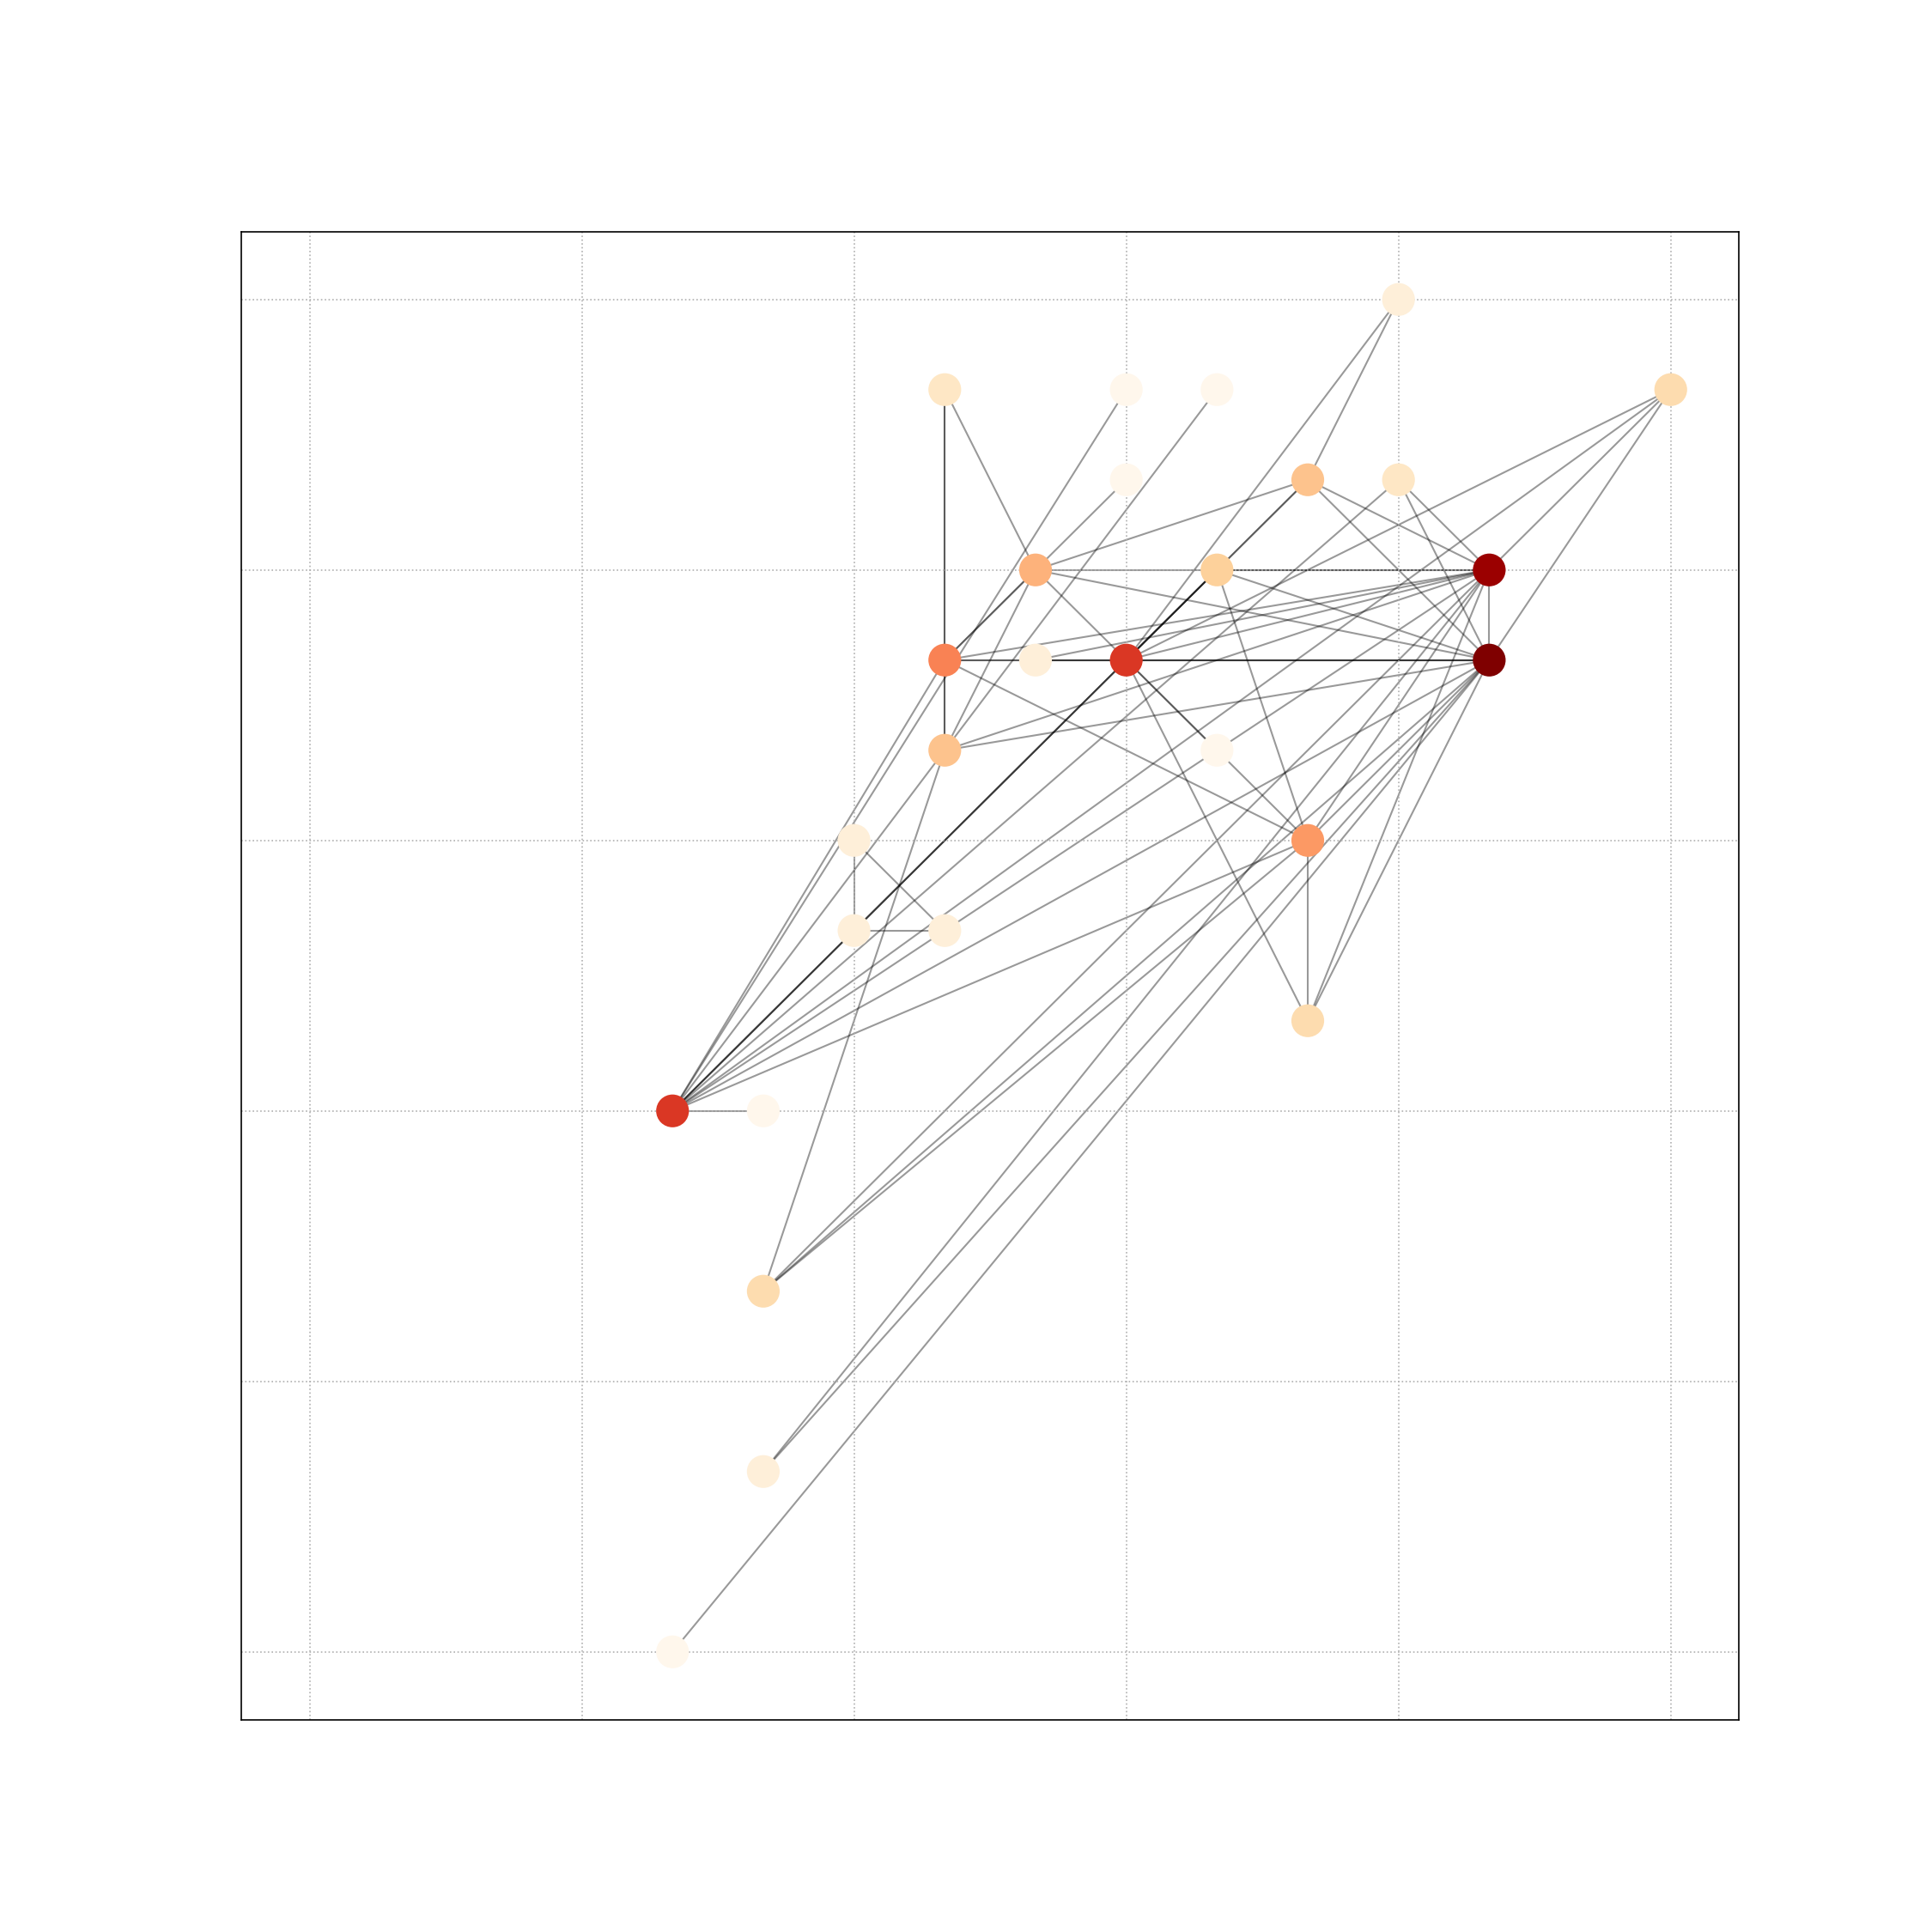

In [255]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

p = nx.degree_centrality(G)

nx.draw_networkx_edges(G, pos, alpha=0.4, ax=ax, cmap='viridis')
nx.draw_networkx_nodes(
    G,
    pos,
    #node_size=([G.nodes[v]['degree_centrality'] for v in G]*10),
    node_size = 300,
    node_color=list(p.values()),
    #edgecolors=
    cmap=plt.cm.OrRd,
    #cmap='viridis',

    ax=ax
)


ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
#ax.set_xticks(columnlist)
ax.grid(ls=':')
#plt.axis("off")
#ax.legend(handles=layer_colors.values(), labels=layer_colors.keys())
'''
layer1 = mpatches.Patch(color='#F28749', label='layer 1')
layer23 = mpatches.Patch(color='#B5D932', label='layer 2/3')
layer4 = mpatches.Patch(color='#8C3A67', label='layer 4')
layer56 = mpatches.Patch(color='#3F93A6', label='layer 5/6')
wm = mpatches.Patch(color='#C9F2EE', label='whitematter')
plt.legend(handles=[layer1, layer23, layer4, layer56, wm])
'''

plt.show()

#fig.savefig('pseudo_anatomy_burst_graph_directions'+filebase+'_.png', dpi = 300, transparent=True)
#fig.savefig('cortex_div11_aCSF_ID046_30µMNorepinephrine_spont_1_burst_connections_dic_graph.png', dpi=300, bbox_inches='tight')


<IPython.core.display.Javascript object>


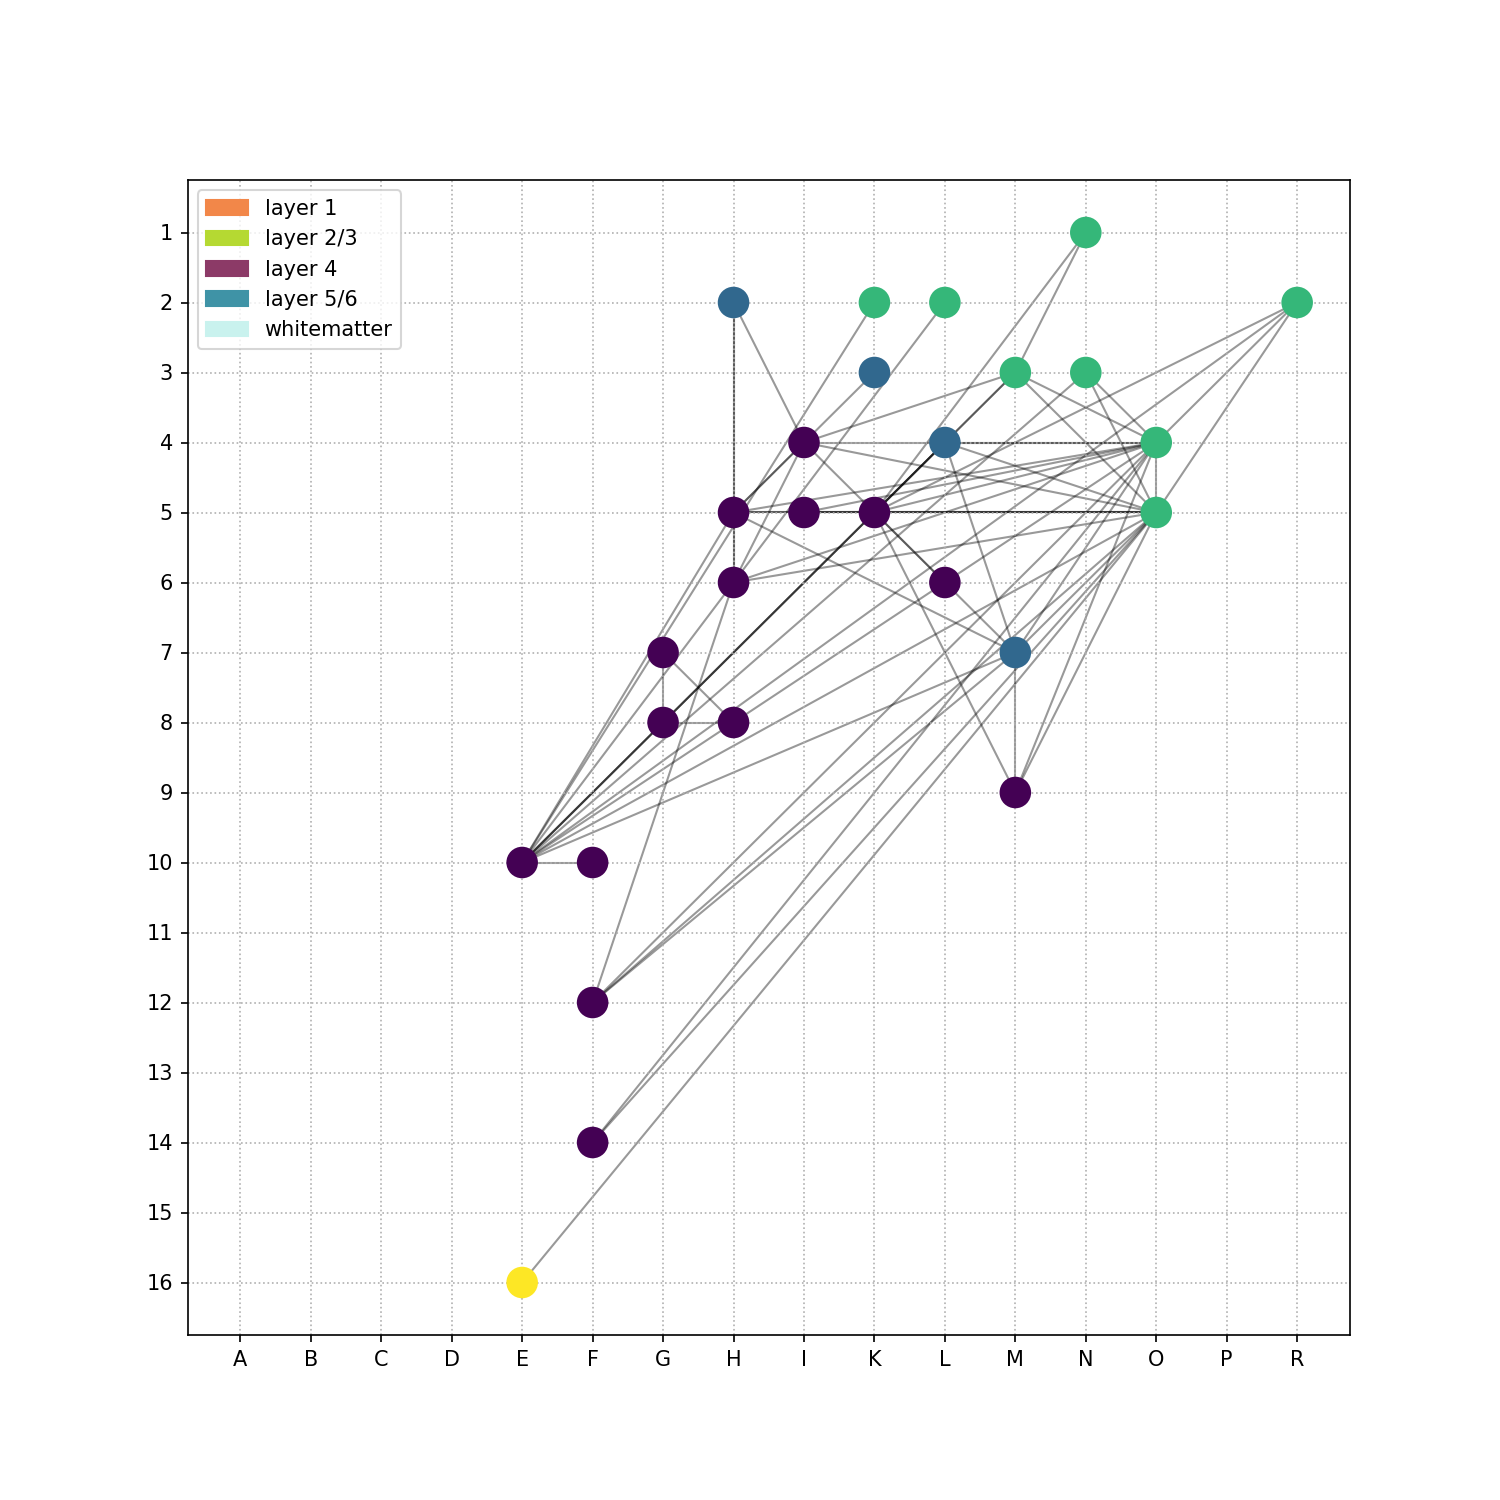

<ipython-input-266-b1d880874c22>:42: UserWarning: Legend does not support '#F28749' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  ax.legend(handles=layer_colors.values(), labels=layer_colors.keys())
<ipython-input-266-b1d880874c22>:42: UserWarning: Legend does not support '#B5D932' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  ax.legend(handles=layer_colors.values(), labels=layer_colors.keys())
<ipython-input-266-b1d880874c22>:42: UserWarning: Legend does not support '#8C3A67' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  ax.legend(handles=layer_colors.values(), labels=layer_colors.keys())
<ipython-input-266-

In [266]:
fig, ax = plt.subplots(1,1, figsize=(10,10))


nx.draw_networkx_edges(
    G,
    pos, 
    alpha=0.4, 
    edge_color='#000000',
    ax=ax,
)


from itertools import count
# get unique groups
groups = set(nx.get_node_attributes(G,'color').values())
mapping = dict(zip(sorted(groups),count()))


nodes = G.nodes()
colors = [mapping[G.nodes[n]['color']] for n in nodes]


nx.draw_networkx_nodes(
    G,
    pos,
    node_size=200,
    node_color=colors,
    #cmap='viridis',
    ax=ax
)


ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.set_xticks(mea_coordinates)
ax.set_yticks(mea_coordinates)
ax.set_xticklabels(columnlist)
ax.set_yticklabels([16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1])

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

ax.grid(ls=':')
#plt.axis("off")
ax.legend(handles=layer_colors.values(), labels=layer_colors.keys())
layer1 = mpatches.Patch(color='#F28749', label='layer 1')
layer23 = mpatches.Patch(color='#B5D932', label='layer 2/3')
layer4 = mpatches.Patch(color='#8C3A67', label='layer 4')
layer56 = mpatches.Patch(color='#3F93A6', label='layer 5/6')
wm = mpatches.Patch(color='#C9F2EE', label='whitematter')
plt.legend(handles=[layer1, layer23, layer4, layer56, wm])

#plt.yticks(mea_coordinates, columnlist)
#plt.xticks(list(mea_coordinates), columnlist)
plt.show()

#fig.savefig('pseudo_anatomy_burst_graph_'+filebase+'_.png', dpi = 300, transparent=True)

In [267]:
groups

{'#3F93A6', '#8C3A67', '#B5D932', '#C9F2EE'}

In [269]:
G.nodes['E16']

{'pos': [0.26666666666666666, 0.0],
 'layer': 'whitematter',
 'color': '#C9F2EE',
 'degree_centrality': 0.038461538461538464}